In [264]:
with open("input.txt") as file:
    valve_information = file.read().split("\n")

In [243]:
valve_information = """Valve AA has flow rate=0; tunnels lead to valves DD, II, BB
Valve BB has flow rate=13; tunnels lead to valves CC, AA
Valve CC has flow rate=2; tunnels lead to valves DD, BB
Valve DD has flow rate=20; tunnels lead to valves CC, AA, EE
Valve EE has flow rate=3; tunnels lead to valves FF, DD
Valve FF has flow rate=0; tunnels lead to valves EE, GG
Valve GG has flow rate=0; tunnels lead to valves FF, HH
Valve HH has flow rate=22; tunnel leads to valve GG
Valve II has flow rate=0; tunnels lead to valves AA, JJ
Valve JJ has flow rate=21; tunnel leads to valve II""".split("\n")

In [265]:
import parse

In [266]:
def parse_valves(valve_information):
    information = parse.parse("Valve {} has flow rate={}; tunnels lead to valves {}", valve_information)
    if information is None:
        information = parse.parse("Valve {} has flow rate={}; tunnel leads to valve {}", valve_information)
    tunnels = [tunnel.strip() for tunnel in information[2].split(",")]
    return {information[0]:{"node":information[0],"flow_rate": int(information[1]), "tunnels":tunnels, "open":False}}

In [267]:
all_valves = {}
for valve in valve_information:
    all_valves |= parse_valves(valve)

In [268]:
valves_with_flow = []
for valve in all_valves:
    flow_rate = all_valves[valve]["flow_rate"]
    if flow_rate > 0:
        valves_with_flow.append(valve)
len(valves_with_flow)

15

In [269]:
import networkx as nx

In [270]:
G = nx.Graph()

In [271]:
for node in all_valves:
    G.add_node(
        node,
        current_flowrate=0,
        opened=0,
        max_flowrate=all_valves[node]["flow_rate"],
        time_taken=1,
    )


In [272]:
for node in all_valves:
    for end_node in all_valves[node]["tunnels"]:
        G.add_edge(node, end_node, time_taken=1)

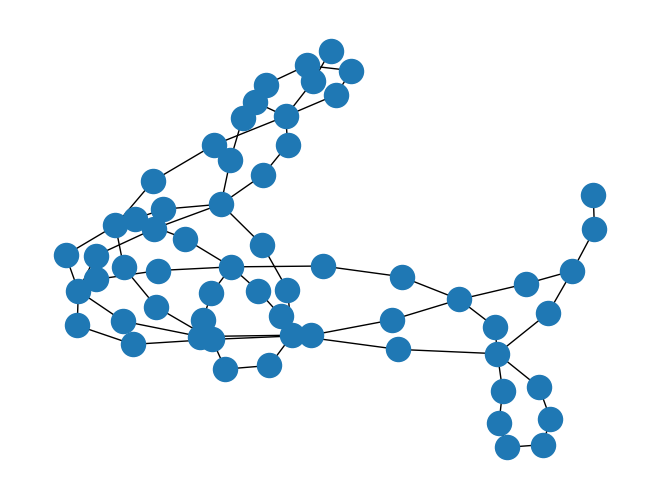

In [273]:
nx.draw(G)

In [274]:
distances = nx.floyd_warshall(G, "time_taken")

In [275]:
def calculate_score(current_valve: str, remaining_time: int, open: list[str]):
    score = {}
    time = {}
    for valve in distances[current_valve]:
        if current_valve != valve and valve in valves_with_flow and valve not in open:
            score[valve] = all_valves[valve]["flow_rate"] * (remaining_time - distances[current_valve][valve] -1)
            time[valve] = distances[current_valve][valve] + 1
    return score, time

In [276]:
import nested_lookup

## Part 1

In [ ]:
time = 0
MAX_TIME = 30
current_valves = ["AA"]
state_machine = {"AA": {"time": 0, "presure_opportunity": 0, "open": []}}
updates_occur = [True]
while any(updates_occur):
    updates_occur = [False]
    new_values = []
    current_states = list(state_machine.keys())
    for valve in current_states:
        single_valve = valve.split("_")[-1]
        remaining_valves = any([flow_valve not in state_machine[valve]["open"] for flow_valve in valves_with_flow])
        remaining_time = MAX_TIME - state_machine[valve]["time"]
        if remaining_time > 0 and remaining_valves:
            updates_occur.append(True)
            scores, times = calculate_score(
                single_valve, remaining_time, state_machine[valve]["open"]
            )
            new_values += scores.keys()
            for new_valve in scores:
                state_machine[f"{valve}_{new_valve}"] = {
                    "time": state_machine[valve]["time"] + times[new_valve],
                    "presure_opportunity": state_machine[valve]["presure_opportunity"]
                    + scores[new_valve],
                    "open": state_machine[valve]["open"] + [new_valve],
                }
        if remaining_valves:
            state_machine.pop(valve)
    print(max(nested_lookup.nested_lookup("time",state_machine)))
    current_valves = new_values.copy()
max(nested_lookup.nested_lookup("presure_opportunity",state_machine))

6
14
19
23
27
29
29


1651

## Part 2

In [277]:
def calculate_score_multi(
    current_valves: str,
    remaining_time: int,
    open: list[str],
    remaining_time_h: int,
    remaining_time_e: int,
):
    score = {}
    elephant_score = {}
    human_score = {}
    time = {}
    elephant_time = {}
    human_time = {}
    human = current_valves.split("|")[0]
    elephant = current_valves.split("|")[1]
    for valve in distances[human]:
        if human != valve and valve in valves_with_flow and valve not in open:
            human_score[valve] = all_valves[valve]["flow_rate"] * (
                remaining_time_h - distances[human][valve] - 1
            )
            human_time[valve] = distances[human][valve] + 1
    for valve in distances[elephant]:
        if elephant != valve and valve in valves_with_flow and valve not in open:
            elephant_score[valve] = all_valves[valve]["flow_rate"] * (
                remaining_time_e - distances[elephant][valve] - 1
            )
            elephant_time[valve] = distances[elephant][valve] + 1

    for el in elephant_score:
        for hu in human_score:
            if hu == el:
                continue
            else:
                score[f"{hu}|{el}"] = human_score[hu] + elephant_score[el]
    return score, human_time, elephant_time


In [313]:
def save_best_states(a, b, opened, pressure):
    if pressure < target_best:
        return False

    key = (a, b, tuple(opened))

    if key not in best or pressure > best[key]:
        best[key] = pressure
        return True
        
    return False

In [308]:
from tqdm import tqdm
from collections import OrderedDict

In [336]:
MAX_TIME = 26
best = {}
target_best = 0
best_history = []

state_machine = OrderedDict(
    {
        "AA|AA": {
            "time_h": 0,
            "time_e": 0,
            "presure_opportunity": 0,
            "open": [],
        },
    }
)
updates_occur = [True]
alloweds = ["AA|AA"]
for time in range(1, MAX_TIME + 1):
    print(f"Filling; lengte best {len(best)}")
    updates_occur = [False]
    new_values = []
    best_history.append(0 if len(best) == 0 else max(best.values()))
    actionable_states = list(state_machine.keys())
    if len(best_history) > 3 and sum(best_history[-3:]) == best_history[-1] * 3:
        print(best_history[-1])
        break
    next_state_machine = {}
    for state in tqdm(actionable_states):
        single_valve = state.split("_")[-1]
        remaining_time = min(
            MAX_TIME - state_machine[state]["time_h"],
            MAX_TIME - state_machine[state]["time_e"],
        )
        best_change = max(x["flow_rate"] for x in all_valves.values()) * (remaining_time)
        target_best = int(best_history[-1] - best_change)
        (scores, human_time, elephant_time) = calculate_score_multi(
            single_valve,
            remaining_time,
            state_machine[state]["open"],
            MAX_TIME - state_machine[state]["time_h"],
            MAX_TIME - state_machine[state]["time_e"],
        )
        for new_valve in scores:
            human_valve = new_valve.split("|")[0]
            elephant_valve = new_valve.split("|")[1]
            if save_best_states(
                human_valve,
                elephant_valve,
                state_machine[state]["open"] + [*new_valve.split("|")],
                state_machine[state]["presure_opportunity"] + scores[new_valve],
            ):
                next_state_machine[f"{state}_{new_valve}"] = {
                    "time_h": state_machine[state]["time_h"] + human_time[human_valve],
                    "time_e": state_machine[state]["time_e"]
                    + elephant_time[elephant_valve],
                    "presure_opportunity": state_machine[state]["presure_opportunity"]
                    + scores[new_valve],
                    "open": state_machine[state]["open"] + [*new_valve.split("|")],
                }
    state_machine = next_state_machine.copy()
print(best_history[-1])

Filling; lengte best 0


100%|██████████| 1/1 [00:00<00:00, 663.55it/s]


Filling; lengte best 210


100%|██████████| 210/210 [00:00<00:00, 1070.86it/s]


Filling; lengte best 32970


100%|██████████| 32760/32760 [00:13<00:00, 2343.66it/s]


Filling; lengte best 557630


100%|██████████| 524660/524660 [02:44<00:00, 3192.92it/s]


Filling; lengte best 893334


100%|██████████| 335704/335704 [01:25<00:00, 3932.57it/s]


Filling; lengte best 969480


100%|██████████| 76146/76146 [00:15<00:00, 4821.49it/s]


Filling; lengte best 974858


100%|██████████| 5378/5378 [00:00<00:00, 5614.85it/s]


Filling; lengte best 974968


100%|██████████| 110/110 [00:00<00:00, 5900.07it/s]

Filling; lengte best 974968
2772
2772
